The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


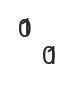

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import torch
from torch import nn
import torch.nn.functional as F
import glob
# Here you import other functions and classes
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import encode_batch, AA_KEYS, BL62_VALUES, BL62FREQ_VALUES, HLAS, BL50, BL50_VALUES
from src.models import NNAlignEFSinglePass
from src.datasets import NNAlignDatasetEFSinglePass

In [3]:
df = pd.read_csv('../data/mhc1_el_sub10k/sample_no_u.csv')

In [36]:
df200 = pd.read_csv('../data/mhc1_el_subsample/mhc1_el_200k_subsample.csv')
df200['len'] = df200['sequence'].apply(len)
df500 = pd.read_csv('../data/mhc1_el_subsample/mhc1_el_500k_subsample.csv')
df500['len'] = df500['sequence'].apply(len)

df200['flag'] = df200.apply(lambda x: any([z not in AA_KEYS for z in x['sequence']]), axis=1)
df500['flag'] = df500.apply(lambda x: any([z not in AA_KEYS for z in x['sequence']]), axis=1)

In [45]:
df200.query('pseudoseq.str.contains("X")')

,sequence,target,HLA,pseudoseq,fold,len,flag
635,IVALILSTK,1.0,HLA-A68:01,YGLIVASTKXXX,0,9,False
975,EENNSFQRL,1.0,HLA-B44:03,PAEEENQRLSPX,0,9,False
1057,KMKEALLSIGK,1.0,HLA-A03:01,MTKKMKIGKXXX,0,11,False
2105,VVNPKYEGK,1.0,HLA-A03:01,VTTVVNEGKXXX,0,9,False
2336,GANSKLTFGKG,0.0,HLA-B44:03,XYTGANGKGITL,0,11,False
...,...,...,...,...,...,...,...
195692,GRLLIQPGPRF,1.0,HLA-B27:01,KPYGRLPRFHXX,4,11,False
195894,YFDLWGRGTLVT,0.0,HLA-A24:02,XYWYFDLVTVSS,4,12,False
196815,DGQKLLFARGTML,0.0,HLA-B51:01,XFSDGQTMLKVD,4,13,False
197104,YFDLWGRGTLVT,0.0,HLA-A24:02,XYWYFDLVTVSS,4,12,False


In [212]:
df200 = df200.query('not flag').rename(columns={'pseudoseq':'context'})
df500 = df500.query('not flag').rename(columns={'pseudoseq':'context'})


In [225]:
from src.data_processing import PSEUDOSEQDICT
df200['pseudoseq'] = df200['HLA'].map(PSEUDOSEQDICT)
df500['pseudoseq'] = df500['HLA'].map(PSEUDOSEQDICT)
print(df500['pseudoseq'].isna().any())
df200.to_csv('../data/mhc1_el_subsample/mhc1_el_200k_subsample.csv', index=False)
df500.to_csv('../data/mhc1_el_subsample/mhc1_el_500k_subsample.csv', index=False)

False


In [295]:
%ls ../data/mhc1_el_subsample

MHC_pseudo.dat              mhc1_el_500k_subsample.csv
README                      mhc1_el_sub10k/
mhc1_el_200k_subsample.csv  test_data.csv


In [242]:
import glob

for f in glob.glob('../data/mhc1_el_sub10k/*.csv'):
    df = pd.read_csv(f)
    df.rename(columns = {'pseudoseq':'context'}, inplace=True)
    df['pseudoseq'] = df['HLA'].map(PSEUDOSEQDICT)
    assert not df['pseudoseq'].isna().any(), f'{f}wtf man,'
    df.to_csv(f, index=False)

In [293]:
sample = pd.concat([df200.query('HLA=="HLA-A02:01"').sample(100, random_state=13), df200.query('HLA!="HLA-A02:01"').sample(100, random_state=13)])
sample.to_csv('../data/mhc1_el_subsample/test_data.csv', index=False)

# testing on the fly batching

In [281]:
from torch.utils.data import SequentialSampler
from src.datasets import NNAlignDatasetEFSinglePass
dataset = NNAlignDatasetEFSinglePass(sample, 13, 9, 'BL50LO', pad_scale=-20, add_pseudo_sequence=True, indel=True)
loader = dataset.get_dataloader(50, SequentialSampler)
for batch_normal in loader:
    continue

In [284]:
batch_normal[0].shape, batch_normal[1].shape, batch_normal[2].shape, batch_normal[3].shape

(torch.Size([50, 15, 180]),
 torch.Size([50, 15, 1]),
 torch.Size([50, 680]),
 torch.Size([50, 1]))

In [264]:
from src.data_processing import encode
encoding = 'BL50LO'
pad_scale = -20
pseudoseq_tensormap = {k: encode(v, 34, encoding, pad_scale).unsqueeze(0) for k,v in PSEUDOSEQDICT.items()}
hlas = sample['HLA'].values
idx = 0
pseudoseq_tensormap[hlas[idx]]

tensor([[[-2., -1., -2., -3., -3., -1., -2., -3.,  2., -1., -1., -2.,  0.,  4.,
          -3., -2., -2.,  2.,  8., -1.],
         [-3., -3., -4., -5., -2., -4., -3., -4., -1.,  0.,  1., -4.,  0.,  8.,
          -4., -3., -2.,  1.,  4., -1.],
         [ 5., -2., -1., -2., -1., -1., -1.,  0., -2., -1., -2., -1., -1., -3.,
          -1.,  1.,  0., -3., -2.,  0.],
         [-1., -2., -2., -4., -2.,  0., -2., -3., -1.,  2.,  3., -2.,  7.,  0.,
          -3., -2., -1., -1.,  0.,  1.],
         [-2., -1., -2., -3., -3., -1., -2., -3.,  2., -1., -1., -2.,  0.,  4.,
          -3., -2., -2.,  2.,  8., -1.],
         [ 0., -3.,  0., -1., -3., -2., -3.,  8., -2., -4., -4., -2., -3., -4.,
          -2.,  0., -2., -3., -3., -4.],
         [-1.,  0.,  0.,  2., -3.,  2.,  6., -3.,  0., -4., -3.,  1., -2., -3.,
          -1., -1., -1., -3., -2., -3.],
         [-1.,  3.,  0., -1., -3.,  2.,  1., -2.,  0., -3., -3.,  6., -2., -4.,
          -1.,  0., -1., -3., -2., -3.],
         [ 0., -3., -3., -4., -1

In [286]:
import torch
import torch.nn.functional as F
from src.datasets import SuperDataset
from src.data_processing import encode_batch, PFR_calculation, FR_lengths, pep_len_1hot, batch_insertion_deletion, batch_indel_mask, PSEUDOSEQDICT

class TestDataset(SuperDataset):
    """
    CLASS TO USE
    """

    # @profile
    def __init__(self, df: pd.DataFrame, max_len: int, window_size: int, encoding: str = 'onehot',
                 seq_col: str = 'sequence', target_col: str = 'target', pad_scale: float = None, indel: bool = False,
                 burnin_alphabet: str = 'ILVMFYW', feature_cols: list = ['placeholder'],
                 add_pseudo_sequence=False, pseudo_seq_col: str = 'pseudoseq', add_pfr=False, add_fr_len=False,
                 add_pep_len=False, add_z=True):
        # start = dt.now()
        super(TestDataset, self).__init__()
        # Encoding stuff
        if feature_cols is None:
            feature_cols = []
        # Filter out sequences longer than max_len
        df['len'] = df[seq_col].apply(len)
        df = df.query('len<=@max_len')
        # Then, if indel is False, filter out sequences shorter than windowsize (ex: 8mers for WS=9)
        if not indel:
            df = df.query('len>=@window_size')

        matrix_dim = 20
        # query_time = dt.now()
        x = encode_batch(df[seq_col], max_len, encoding, pad_scale)
        y = torch.from_numpy(df[target_col].values).float().view(-1, 1)
        # encode_time = dt.now()
        # Creating the mask to allow selection of kmers without padding
        len_mask = torch.from_numpy(df['len'].values)
        x_mask = len_mask - window_size
        range_tensor = torch.arange(max_len - window_size + 1).unsqueeze(0).repeat(len(x), 1)
        # Mask for Kmers + padding
        x_mask = (range_tensor <= x_mask.unsqueeze(1)).float().unsqueeze(-1)
        # Expand the kmers windows for base sequence without indels
        x = x.unfold(1, window_size, 1).transpose(2, 3) \
             .reshape(len(x), max_len - window_size + 1, window_size, matrix_dim)
        # Creating indels window and mask 
        if indel:
            x_indel = batch_insertion_deletion(df[seq_col], max_len, encoding, pad_scale, window_size)
            # remove padding from indel windows
            x_indel = x_indel[:,:,:window_size, :]
            indel_mask = batch_indel_mask(len_mask, window_size)
            x = torch.cat([x, x_indel], dim=1)
            x_mask = torch.cat([x_mask, indel_mask], dim=1)
        
        # Creating another mask for the burn-in period+bool flag switch
        self.burn_in_mask = _get_burnin_mask_batch(df[seq_col].values, max_len, window_size, burnin_alphabet).unsqueeze(
            -1)
        self.burn_in_flag = False

        # Expand and unfold the sub kmers and the target to match the shape ; contiguous to allow for view operations
        self.x_tensor = x.flatten(2, 3).contiguous()
        self.x_mask = x_mask
        
        self.pseudoseq_tensormap = {k: encode(v, 34, encoding, pad_scale).unsqueeze(0).flatten(start_dim=1) for k,v in PSEUDOSEQDICT.items()}
        # kmer_time = dt.now()
        self.y = y.contiguous()
        self.x_features = torch.empty((len(x),))
        # Add extra features
        if len(feature_cols) > 0:
            # TODO: When you add more features you need to concatenate to x_pseudosequence and save it to self.x_features
            # these are NUMERICAL FEATURES like %Rank, expression, etc. of shape (N, len(feature_cols))
            # x_features = torch.from_numpy(df[feature_cols].values).float()

            self.extra_features_flag = True
        else:
            self.extra_features_flag = False

        #  TODO dictmap for 9mer look-up and see if how many duplicated and can we save memory
        #
        if add_pseudo_sequence:
            self.hla_tag = df['HLA'].values
            self.extra_features_flag = True
            # ps_time = dt.now()
        if add_pfr:
            x_pfr = PFR_calculation(df[seq_col], self.x_mask, max_len, window_size)
            self.x_tensor = torch.cat([self.x_tensor, x_pfr], dim=2)
            # pfr_time = dt.now()
        if add_fr_len:
            x_fr_len = FR_lengths(self.x_mask, max_len, window_size)
            self.x_tensor = torch.cat([self.x_tensor, x_fr_len], dim=2)
            # pfr_len_time = dt.now()
        if add_pep_len:
            x_pep_len = pep_len_1hot(df[seq_col], max_len, window_size, min_length=13, max_length=21)
            self.x_tensor = torch.cat([self.x_tensor, x_pep_len], dim=2)
            # peplen_time = dt.now()

        # Saving df in case it's needed
        self.df = df
        self.len = len(x)
        self.max_len = max_len
        self.seq_col = seq_col
        self.window_size = window_size

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        """ Returns the appropriate input tensors (X, ..., y) depending on the bool flags
        A bit convoluted return, but basically 4 conditions:
            1. No burn-in, no extra features --> returns the normal x_tensor, kmers mask, target
            2. Burn-in, no extra features --> returns the normal x_tensor, burn-in mask, target
            3. No Burn-in, + extra features --> returns the normal x_tensor, kmers mask, x_features, target
            4. Burn-in, + extra features --> returns the normal x_tensor, burn-in mask, x_features, target
        :param idx:
        :return:
        """
        if self.burn_in_flag:
            if self.extra_features_flag:
                x_pseudoseq = self.pseudoseq_tensormap[self.hlas[idx]]
                return self.x_tensor[idx], self.burn_in_mask[idx], x_pseudoseq, self.y[idx]
            else:
                # 2
                return self.x_tensor[idx], self.burn_in_mask[idx], self.y[idx]
        else:
            if self.extra_features_flag:
                # 3
                return self.x_tensor[idx], self.x_mask[idx], x_pseudoseq, self.y[idx]
            else:
                # 1
                return self.x_tensor[idx], self.x_mask[idx], self.y[idx]

    def burn_in(self, flag):
        self.burn_in_flag = flag

def _get_burnin_mask_batch(sequences, max_len, motif_len, alphabet='ILVMFYW'):
    return torch.stack([_get_burnin_mask(x, max_len, motif_len, alphabet) for x in sequences])


def _get_burnin_mask(seq, max_len, motif_len, alphabet='ILVMFYW'):
    mask = torch.tensor([x in alphabet for i, x in enumerate(seq) if i < len(seq) - motif_len + 1]).float()
    return F.pad(mask, (0, (max_len - motif_len + 1) - len(mask)), 'constant', 0)


In [287]:
testdataset = TestDataset(sample, 13, 9, 'BL50LO', pad_scale=-20, add_pseudo_sequence=True, indel=True)
testloader = dataset.get_dataloader(50, SequentialSampler)
for batch in testloader:
    continue

In [289]:
(batch[0]==batch_normal[0]).all()

tensor(True)

In [290]:
(batch[2]==batch_normal[2]).all()

tensor(True)

In [288]:
batch[0].shape, batch[1].shape, batch[2].shape, batch[3].shape

(torch.Size([50, 15, 180]),
 torch.Size([50, 15, 1]),
 torch.Size([50, 680]),
 torch.Size([50, 1]))

# what the init code

In [303]:
from src.datasets import NNAlignDatasetEFSinglePass, PseudoOTFDataset
from src.models import NNAlignEFSinglePass
from src.utils import get_class_initcode_keys

In [305]:
args = {'max_len':13}
get_class_initcode_keys(PseudoOTFDataset, args)

['max_len']

In [312]:
# stupid init code name changes if we profile it ; Need a UglyWorkAround class to get the same init

[autoreload of src.datasets failed: Traceback (most recent call last):
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-pa

In [304]:
PseudoOTFDataset.__init__.__code__.co_varnames

('self',
 'df',
 'max_len',
 'window_size',
 'encoding',
 'seq_col',
 'target_col',
 'pad_scale',
 'indel',
 'burnin_alphabet',
 'feature_cols',
 'add_pseudo_sequence',
 'pseudo_seq_col',
 'add_pfr',
 'add_fr_len',
 'add_pep_len',
 'add_z',
 'matrix_dim',
 'x',
 'y',
 'len_mask',
 'x_mask',
 'range_tensor',
 'x_indel',
 'indel_mask',
 'x_pfr',
 'x_fr_len',
 'x_pep_len')

In [306]:
NNAlignDatasetEFSinglePass.__init__.__code__.co_varnames

('args', 'kwargs', 'prof', 'val')

In [311]:
NNAlignDatasetEFSinglePass.__init__.__code__.

b'\x95\x03\x97\x00\x02\x00\x89\x05\xa6\x00\x00\x00\xab\x00\x00\x00\x00\x00\x00\x00\x00\x00}\x02\x02\x00\x02\x00|\x02\x89\x04\xa6\x01\x00\x00\xab\x01\x00\x00\x00\x00\x00\x00\x00\x00|\x00i\x00|\x01\xa4\x01\x8e\x01}\x03\x02\x00\x89\x06|\x02\xa6\x01\x00\x00\xab\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00|\x03S\x00'

In [301]:
NNAlignEFSinglePass.__init__.__code__.co_varnames

('self',
 'n_hidden',
 'n_hidden_2',
 'window_size',
 'activation',
 'extrafeat_dim',
 'batchnorm',
 'dropout',
 'standardize',
 'add_hidden_layer')

# burn_in mask need to match indel mask

In [368]:
''.join(AA_KEYS)

'ARNDCQEGHILKMFPSTWYV'

In [313]:

def _get_burnin_mask_batch(sequences, max_len, motif_len, alphabet='ILVMFYW'):
    return torch.stack([_get_burnin_mask(x, max_len, motif_len, alphabet) for x in sequences])


def _get_burnin_mask(seq, max_len, motif_len, alphabet='ILVMFYW'):
    mask = torch.tensor([x in alphabet for i, x in enumerate(seq) if i < len(seq) - motif_len + 1]).float()
    return F.pad(mask, (0, (max_len - motif_len + 1) - len(mask)), 'constant', 0)

In [315]:
_get_burnin_mask_batch(sample['sequence'].head(15), 13, 9)

tensor([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [317]:
sample['sequence'].head(15).iloc[0]

'ELEMIKKKHLV'

In [332]:
sample['sequence'].head(15).iloc[1]

'QMEARQKECGA'

In [331]:
sample['sequence'].head(15).iloc[4]

'RQLASEGLPAL'

In [333]:
sample['sequence'].head(15).iloc[-3]

'FLQLMIDSQ'

In [316]:
sample['sequence'].head(15).iloc[-1]

'ADNIYIFLEL'

In [343]:
seq='VELEMIKKKHL'
indel_windows = get_indel_windows(seq, 9)
indel_burnin_mask = torch.tensor([x[0] in alphabet for x in indel_windows]).float()
print(seq, len(seq))
print(indel_windows)
print(indel_burnin_mask, indel_burnin_mask.shape)

VELEMIKKKHL 11
['LEMIKKKHL', 'VEMIKKKHL', 'VEMIKKKHL', 'VELIKKKHL', 'VELEKKKHL', 'VELEMKKHL', 'VELEMIKHL', 'VELEMIKHL', 'VELEMIKKL', 'VELEMIKKK']
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]) torch.Size([10])


In [345]:
def _get_indel_burnin_mask(seq, window_size, alphabet='ILVMFYW'):
    indel_windows = get_indel_windows(seq, window_size)
    return torch.tensor([x[0] in alphabet for x in indel_windows]).float()

def _get_indel_burnin_mask_batch(sequences, window_size, alphabet='ILVMFYW'):
    return torch.stack([_get_indel_burnin_mask(x, window_size, alphabet) for x in sequences])


In [355]:
indel_burnin_mask = _get_indel_burnin_mask_batch(sample['sequence'], 9).unsqueeze(-1)

In [356]:
indel_burnin_mask.shape

torch.Size([200, 10, 1])

In [357]:
dataset.burn_in_mask.shape

torch.Size([200, 5, 1])

In [364]:
torch.cat([dataset.burn_in_mask, indel_burnin_mask], dim=1).shape

torch.Size([200, 15, 1])

# Other stuff could be done on the fly (try to save as little as possible in memory)